In [37]:
import numpy as np
#! pip install pygad
import pygad.gann
#!pip install sklearn
from sklearn import preprocessing
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
#restart anaconda/jupyterlab
from ipywidgets import widgets
from IPython.display import display, clear_output

In [38]:
#solutions_num - liczba rozwiązań np. 5
#input_num - liczba neuronów w warstwie wejściowej np. 3
#hidden_num - ilość neuronów w warstwach ukrytych np. [2] lub [5, 2]
#output_num - liczba neuronów w warstwie wyjściowej np. 1
#hidden_act - rodzaj funkcji aktywacji dla warstw ukrytych np. ["relu"] lub ["sigmoid", "relu"] ("sigmoid", "relu", "softmax", "None")
class NeuralNetwork:
    # Konstruktor sieci neuronowej
    def __init__(self, input_data, output_data, solutions_num, input_layers_num, hidden_layers_num, output_layers_num, hidden_layers_act, output_layers_act):
        if len(hidden_layers_num) != len(hidden_layers_act):
            raise Exception('Number of hidden layers must be equal number of hidden activation functions')
        
        if solutions_num < 2:
            raise Exception('At least one value is required')
        
        # Ustawienie danych wejściowych
        self.input_data = input_data
        # Ustawienie danych wyjściowych ????????????
        self.output_data = output_data
        # Tworzenie sieci neuronowych
        self.instance = pygad.gann.GANN(num_solutions=solutions_num,
                                num_neurons_input=input_layers_num,
                                num_neurons_hidden_layers=hidden_layers_num,
                                num_neurons_output=output_layers_num,
                                hidden_activations=hidden_layers_act,
                                output_activation=output_layers_act)
        # Tablica populacji
        self.population_array = pygad.gann.population_as_vectors(population_networks=self.instance.population_networks)
    # Wypisanie wag każdej sieci
    def PrintWeights(self):
        for i, val in enumerate(self.population_array):
            print(f'Network number: {i}')
            for j, value in enumerate(val):
                print(f'Weight {j}: {value}')
            print("\n")

# neural_network - instancja klasy NeuralNetwork
# generation_num - liczba generacji(iteracji)
# parent_num - liczba rodziców z których powstaną nowe osobniki
# mutation_perc - procent szansy na mutację
class GeneticAlgorithm:
    def __init__(self, neural_network, generation_num, parent_num, mutation_perc):
        if parent_num > neural_network.instance.num_solutions:
            raise Exception('parents number cannot be higher than population number')
        
        self.instance = pygad.GA(num_generations=generation_num, 
                       num_parents_mating=parent_num, 
                       initial_population=neural_network.population_array.copy(),
                       fitness_func=fitness_function,
                       mutation_percent_genes=mutation_perc,
                       on_generation=on_generation)
    
    def run(self):
        self.instance.run()
    
    def plot_result(self):
        self.instance.plot_result()
        
    def best_result(self):
        solution, solution_fitness, solution_idx = self.instance.best_solution()
        print(f'Solution: {solution}')
        print(f'Solution fitness: {solution_fitness}')
        print(f'Solution index: {solution_idx}')
        
# Obliczanie funkcji dopasowania
def fitness_function(solution, solution_index):
    global nn
    predictions = pygad.nn.predict(last_layer=nn.instance.population_networks[solution_index],
                                   data_inputs=nn.input_data,
                                   problem_type="classification")
    correct_predictions = np.where(predictions == nn.output_data)[0].size
    solution_fitness = (correct_predictions/nn.output_data.size)*100
    return solution_fitness

# Funkcja aktualizująca wagi
def on_generation(ga_instance):
    global nn, ga
    
    population_matrices = pygad.gann.population_as_matrices(population_networks=nn.instance.population_networks,
                                                            population_vectors=ga.instance.population)
    nn.instance.update_population_trained_weights(population_trained_weights=population_matrices)

    #print("Generation = {generation}".format(generation=ga.instance.generations_completed))
    #print("Accuracy   = {fitness}".format(fitness=ga.instance.best_solution()[1]))

In [39]:
data = np.genfromtxt('diabetes.csv', delimiter=',')
cols = data[:,:8] # pierwsze 8 kolumn
last_cols = data[:,8] # ostatnia kolumna (nr 9)
min_max_scaler = preprocessing.MinMaxScaler()
data_inputs = min_max_scaler.fit_transform(cols.T).T
data_outputs = last_cols

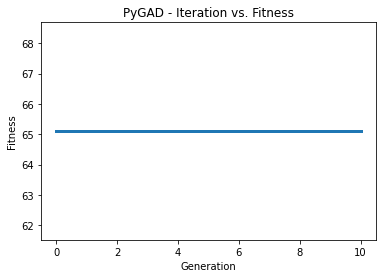

Solution: [-0.09111914 -0.04035347  0.04463967  0.05380751  0.38997394  0.01349054
 -0.05608955  0.99094103 -0.03682982  0.0174559   0.06339885  0.08672926
  0.01438623  0.09505997 -0.09977631 -0.76273992  0.03184367 -0.59624692
  0.09582772  0.07622038  0.84562613  0.09816805 -0.27593662  0.01626128
  0.03484029  0.01205797 -0.07346886  0.17245232 -0.0600077  -0.00599617
  0.04125183 -0.09235753  0.021881    0.03174215]
Solution fitness: 65.10416666666666
Solution index: 0


In [40]:
nn = NeuralNetwork(input_data=data_inputs, 
                  output_data=data_outputs, 
                  solutions_num=10, 
                  input_layers_num=8, 
                  hidden_layers_num=[3, 2], 
                  output_layers_num=2,
                  hidden_layers_act=["relu", 'relu'], 
                  output_layers_act="softmax")

ga = GeneticAlgorithm(neural_network=nn,
                      generation_num=10,
                      parent_num=2,
                      mutation_perc=5)
ga.run()
ga.plot_result()
ga.best_result()

In [42]:
style = {'description_width': 'initial'}
layout=widgets.Layout(width='70%')

# Defining inputs
solnum = widgets.IntText(value='10', description='Solution number(int)', style=style, layout=layout)
iln = widgets.IntText(value='8', description='Input layers number(int)', style=style, layout=layout)
hln = widgets.Text(value='2, 2', description='Hidden layers number(ints seperated by comma)', style=style, layout=layout)
oln = widgets.IntText(value='2', description='Output layers number(int)', style=style, layout=layout)
hla = widgets.Text(value='relu, relu', description='Hidden layers activation function(strings separated by comma)', style=style, layout=layout)
ola = widgets.Text(value='softmax', description='Output layers activation function(string)', style=style, layout=layout)
gennum = widgets.IntText(value='100', description='Generations number(int)', style=style, layout=layout)
parnum = widgets.IntText(value='5', description='Parents number(int)', style=style, layout=layout)
mutperc = widgets.IntText(value='5', description='Mutation percentage(int)', style=style, layout=layout)

# Displaying inputs
display(solnum)
display(iln)
display(hln)
display(oln)
display(hla)
display(ola)
display(gennum)
display(parnum)
display(mutperc)

# Defining button
btn = widgets.Button(description="Submit", button_style='success')

# Defining output field
out = widgets.Output()

# Button handler
def on_btn_clicked(b):
    with out:
        global nn, ga
        # Clearing output
        clear_output()
        
        # Layers to int array
        a = hln.value.split(',')
        a = list(map(int, a))
        
        # Layers act. func. to string array
        b = hla.value.replace(" ", "").split(',')
        
        # Creating neural network
        nn = NeuralNetwork(input_data=data_inputs, 
                      output_data=data_outputs, 
                      solutions_num=solnum.value, 
                      input_layers_num=iln.value, 
                      hidden_layers_num=a, 
                      output_layers_num=oln.value,
                      hidden_layers_act=b, 
                      output_layers_act=ola.value)

        # Creating genetic algorithm
        ga = GeneticAlgorithm(neural_network=nn,
                          generation_num=gennum.value,
                          parent_num=parnum.value,
                          mutation_perc=mutperc.value)
        ga.run()
        ga.plot_result()
        ga.best_result()

# Setting handler
btn.on_click(on_btn_clicked)

# Displaying button and output
display(btn)
display(out)

IntText(value=10, description='Solution number(int)', layout=Layout(width='70%'), style=DescriptionStyle(descr…

IntText(value=8, description='Input layers number(int)', layout=Layout(width='70%'), style=DescriptionStyle(de…

Text(value='2, 2', description='Hidden layers number(ints seperated by comma)', layout=Layout(width='70%'), st…

IntText(value=2, description='Output layers number(int)', layout=Layout(width='70%'), style=DescriptionStyle(d…

Text(value='relu, relu', description='Hidden layers activation function(strings separated by comma)', layout=L…

Text(value='softmax', description='Output layers activation function(string)', layout=Layout(width='70%'), sty…

IntText(value=100, description='Generations number(int)', layout=Layout(width='70%'), style=DescriptionStyle(d…

IntText(value=5, description='Parents number(int)', layout=Layout(width='70%'), style=DescriptionStyle(descrip…

IntText(value=5, description='Mutation percentage(int)', layout=Layout(width='70%'), style=DescriptionStyle(de…

Button(button_style='success', description='Submit', style=ButtonStyle())

Output()